In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

route_delay_path = DATA_PROCESSED / "route_delay_kpis.csv"
route_sched_path = DATA_PROCESSED / "route_schedule_kpis.csv"

route_delay = pd.read_csv(route_delay_path)
route_sched = pd.read_csv(route_sched_path)

route_delay.head(), route_sched.head()


(    route_id  route_short_name            route_long_name  n_events  \
 0  19118_700               468  PlusBus Nationalparklinie         4   
 
    avg_delay_min  share_over_5min  share_on_time_or_early  impact_score  
 0            1.0              0.0                     0.5           4.0  ,
     route_id route_short_name route_long_name  route_type  n_trips
 0  10141_109               S1             NaN         109      563
 1  10142_109               S1             NaN         109      439
 2  10143_109               S2             NaN         109      643
 3  10144_109               S2             NaN         109      274
 4  10145_109              S25             NaN         109      231)

In [3]:
# Merge delay KPIs with schedule KPIs using route_id only
# (route_short_name has different dtypes across files, so we avoid merging on it)

# make sure route_id is the same type in both
route_sched["route_id"] = route_sched["route_id"].astype(str)
route_delay["route_id"] = route_delay["route_id"].astype(str)

routes = pd.merge(
    route_sched,
    route_delay,
    on="route_id",
    how="left",
    suffixes=("_sched", "_delay"),
)

# Rebuild clean route names after merge:
# prefer the schedule version (_sched), fall back to delay version (_delay) if needed
for base in ["route_short_name", "route_long_name"]:
    sched_col = f"{base}_sched"
    delay_col = f"{base}_delay"

    # if delay col doesn't exist (just in case), create it as empty
    if delay_col not in routes.columns:
        routes[delay_col] = None

    routes[base] = routes[sched_col].where(
        routes[sched_col].notna() & (routes[sched_col] != ""),
        routes[delay_col],
    )

# Fill missing delay metrics with zeros (routes with no delay data)
for col in ["n_events", "avg_delay_min", "share_over_5min", "share_on_time_or_early"]:
    if col in routes.columns:
        routes[col] = routes[col].fillna(0)

# Define impact_score: severity * frequency (positive delays only)
routes["impact_score"] = routes["avg_delay_min"].clip(lower=0) * routes["n_events"]

# Normalize key metrics for composite priority score
routes["norm_impact"] = routes["impact_score"] / (routes["impact_score"].max() or 1)
routes["norm_trips"] = routes["n_trips"] / (routes["n_trips"].max() or 1)
routes["norm_share_over_5"] = routes["share_over_5min"] / (routes["share_over_5min"].max() or 1)

# Composite priority score: tweak weights if you want
routes["priority_score"] = (
    0.5 * routes["norm_impact"]
    + 0.3 * routes["norm_trips"]
    + 0.2 * routes["norm_share_over_5"]
)

routes_sorted = routes.sort_values("priority_score", ascending=False).reset_index(drop=True)
routes_sorted.head(10)



,route_id,route_short_name_sched,route_long_name_sched,route_type,n_trips,route_short_name_delay,route_long_name_delay,n_events,avg_delay_min,share_over_5min,share_on_time_or_early,impact_score,route_short_name,route_long_name,norm_impact,norm_trips,norm_share_over_5,priority_score
0,19118_700,468,PlusBus Nationalparklinie,700,56,468.0,PlusBus Nationalparklinie,4.0,1.0,0.0,0.5,4.0,468,PlusBus Nationalparklinie,1.0,0.017995,0.0,0.505398
1,17452_900,M4,NaN,900,3112,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M4,NaN,0.0,1.000000,0.0,0.300000
2,17520_700,U6,NaN,700,3070,NaN,NaN,0.0,0.0,0.0,0.0,0.0,U6,NaN,0.0,0.986504,0.0,0.295951
3,17514_400,U2,NaN,400,2893,NaN,NaN,0.0,0.0,0.0,0.0,0.0,U2,NaN,0.0,0.929627,0.0,0.278888
4,17609_700,M4,NaN,700,2518,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M4,NaN,0.0,0.809126,0.0,0.242738
5,17453_700,M41,NaN,700,2246,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M41,NaN,0.0,0.721722,0.0,0.216517
6,17448_700,M27,NaN,700,2125,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M27,NaN,0.0,0.682841,0.0,0.204852
7,17440_900,M10,NaN,900,2098,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M10,NaN,0.0,0.674165,0.0,0.202249
8,17450_700,M32,NaN,700,1802,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M32,NaN,0.0,0.579049,0.0,0.173715
9,17449_700,M29,NaN,700,1749,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M29,NaN,0.0,0.562018,0.0,0.168605


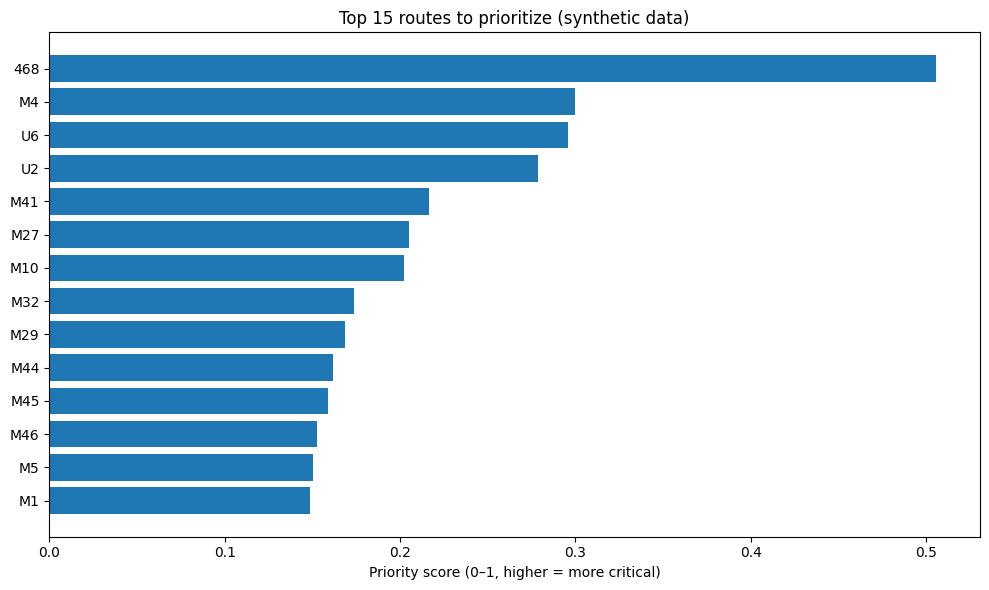

,route_id,route_short_name,route_long_name,n_trips,n_events,avg_delay_min,share_over_5min,impact_score,priority_score
0,19118_700,468,PlusBus Nationalparklinie,56,4.0,1.0,0.0,4.0,0.505398
1,17452_900,M4,NaN,3112,0.0,0.0,0.0,0.0,0.300000
2,17520_700,U6,NaN,3070,0.0,0.0,0.0,0.0,0.295951
3,17514_400,U2,NaN,2893,0.0,0.0,0.0,0.0,0.278888
4,17609_700,M4,NaN,2518,0.0,0.0,0.0,0.0,0.242738
5,17453_700,M41,NaN,2246,0.0,0.0,0.0,0.0,0.216517
6,17448_700,M27,NaN,2125,0.0,0.0,0.0,0.0,0.204852
7,17440_900,M10,NaN,2098,0.0,0.0,0.0,0.0,0.202249
8,17450_700,M32,NaN,1802,0.0,0.0,0.0,0.0,0.173715
9,17449_700,M29,NaN,1749,0.0,0.0,0.0,0.0,0.168605


In [4]:
top_n = 15
top_routes = routes_sorted.head(top_n)

plt.figure(figsize=(10, 6))
labels = top_routes["route_short_name"].fillna(top_routes["route_id"].astype(str))
plt.barh(labels, top_routes["priority_score"])
plt.gca().invert_yaxis()
plt.xlabel("Priority score (0–1, higher = more critical)")
plt.title(f"Top {top_n} routes to prioritize (synthetic data)")
plt.tight_layout()
plt.show()

top_routes[[
    "route_id",
    "route_short_name",
    "route_long_name",
    "n_trips",
    "n_events",
    "avg_delay_min",
    "share_over_5min",
    "impact_score",
    "priority_score",
]]


In [5]:
output_path = DATA_PROCESSED / "prioritized_routes.csv"
routes_sorted.to_csv(output_path, index=False)
output_path


WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/prioritized_routes.csv')